# Hypothesis tests with pyhf

This notebook will provide you with the tools to do sensitivity estimates which can be used for search region optimization or sensitivity projections.

This is an adapted version of the notebook presented [here](https://github.com/nikoladze/HEPFittingTutorial/blob/master/examples/jupyter_notebooks/007_hypothesis_tests_with_pyhf.ipynb). 

## p-value for discovery of a new signal

In searches for new physics we want to know how significant a potential deviation from our Standard Model (SM) expectation is. We do this by a hypothesis test where we try to exclude the SM ("background only") hypothesis. We use a so called **p-value** $P(t_{obs}|H_0)$ for this, abstractly defined by:

$$P(t_{obs}|H_0) = \int\limits_{t_\mathrm{obs}}^{\infty}p(t|H_0)\mathrm{d}t$$

where $t$ is a test statistic (a number we calculate from our data observations) and $p(t|H_0)$ is the probability distribution for $t$ under the assumption of our **null Hypothesis** $H_0$, in this case the background only hypothesis. This p-value is then typically converted into a number of standard deviations $z$, the **significance** ("number of sigmas") via the inverse of the cumulative standard normal distribution $\Phi$:

$$z = \Phi^{-1}(1 - P)$$

The typical convention for particle physics is to speak of *evidence* when $z>3$ and of an *observation* when $z>5$.

So what do we use for $t$? We want to use something that discriminates well between our null Hypothesis and an **alternative Hypothesis** that we have in mind. When we try to discover new physics, our null Hypothesis is the absence and the alternative Hypothesis the presence of a signal. We can parametrize this by a **signal strength** parameter $\mu$. The test statistics used in almost all HEP searches use the **profile likelihood ratio**

$$\lambda(\mu) = \frac{L(\mu, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$$

where $\theta$ are the other parameters of our model that are not part of the test, the so called **nuisance parameters**. In contrast, the parameter that we want to test, $\mu$, is called our **parameter of interest** (POI). The nuisance parameters include all fit parameters, like normalization factors and parameters for describing uncertainties. $L(\mu, \hat{\hat{\theta}})$ is the Likelihood function, maximized under the condition that our parameter of interest takes the value $\mu$ and $L(\hat{\mu}, \hat{\theta})$ is the unconditionally maximized Likelihood. So roughly speaking, we are calculating the fraction of the maximum possible likelihood that we can get under our test condition. If it is high, that speaks for our hypothesis, if it is low, against. The test statistic $t_\mu$ is then defined as

$$t_\mu = -2\ln\lambda(\mu)$$

giving us a test statistic where **high values speak against the null hypothesis**.

**Question:** If we want to discover a new signal (using the p-value $P(t_{obs}|H_0)$), which value of $\mu$ are we testing against? Or in other words, what is our null Hypothesis?


All that's left now is to know the distribution of $p(t_\mu|H_0)$. [Wilk's theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem) tells us that the distribution of $t_\mu$ is asymptotically (for large sample sizes) a chi-square distribution. The asymptotic limit often matches quite well even for fairly small sample sizes, but it should be kept in mind this is an approximation. Alternatively, one can evaluate $p(t_\mu|H_0)$ by Monte Carlo sampling ("toys").

More details on test statistics for different cases and the asymptotic distributions for all different variants can be found in the paper "Asymptotic formulae for likelihood-based tests of new physics" ([arXiv:1007.1727](https://arxiv.org/abs/1007.1727)).


## CLs for exclusion of an absent signal

Now, sadly, not all searches find evidence for new physics. What we still can do in such a case is to try exclude models by rejecting the hypothesis of a signal being present. That usually means we test against $\mu=1$ or some other value $>0$. For establishing an upper limit on the strength parameter $\mu$, we use a slightly modified version of test statistic,

$$ q_\mu= \begin{cases}-2 \ln \lambda(\mu) & \hat{\mu} \geq \mu, \\ 0 & \hat{\mu}<\mu,\end{cases}.$$ 

The rest of the procedure is very similar with one small detail worth mentioning ... In high energy physics it is very common to use a quantity called $CL_s$ instead of plain p-value. It is defined by

$$CL_s = \frac{P(q_{obs}|s+b)}{P(q_{obs}|b)}$$

where $P(q_{obs}|s+b)$ is the p-value for rejecting the hypothesis of signal + background being present (what would be the "normal" p-value) and $P(q_{obs}|b)$ is the p-value for rejecting the background only hypothesis.

Just a qualitative explanation of why we use $CL_s$ instead of the p-value: We want to avoid excluding signals in cases where we don't have sensitivity, but observe an *underfluctuation* of the data. In these cases $P(q_{obs}|s+b)$ and $P(q_{obs}|b)$ will be very similar and consequently lead to a large value of $CL_{s}$, telling us the signal is **not** excluded. In case our observations are exactly on spot with the background expectations $P(q_{obs}|b) = 0.5$ in the asymptotic limit, so on average we have twice as high "p-values" with $CL_s$.

The typical convention for particle physics is to speak of an **exclusion** of a signal if $CL_s < 0.05$. That's usually what is meant by "limit at 95% confidence level".

## Discovery or exclusion of a signal for a cut & count experiment

Let's start with a simple case where we only want to count the number of events in a certain search region. We assume a certain number of expected background events `b`, expected signal events `s` and a total uncertainty on the expected background `delta_b` ($\sigma_b$).

The likelihood function for this can be formulated as a primary measurement of `n` events and a control ("auxiliary") measurment of `m` events that constrains our background parameter within the uncertainty. So, a product of 2 Poisson distributions:

$$L(s, b) = \mathrm{Pois}(n|s + b)\cdot \mathrm{Pois}(m|\tau b)$$

The parameter $\tau$ can be given in terms of $\sigma_b$ by asking the question "How much more events do i have to measure in the control region to get the relative uncertainty $\sigma_b / b$". That gives $\tau = \frac{b}{\sigma_b^2}$.

Equivalently, we can replace $b$ by $\gamma b$ and $s$ by $\mu s$ to fit normalization factors (initialized to 1) and keep $s$ and $b$ fixed to our expectation.

$$L'(\mu, \gamma) = L(\mu s, \gamma b)$$

`pyhf` has a convenience function to create the specification for such a model: `pyhf.simplemodels.uncorrelated_background`. It also works for arbitrary many bins, but for now let's go with one bin and 5 expected background events, 7 expected signal events and an uncertainty of 2 on the expected background events:

In [55]:
import pyhf
from scipy import stats
import numpy as np
import json
import matplotlib.pyplot as plt

In [3]:
s = 7
b = 5
delta_b = 2

In [4]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=[s], bkg=[b], bkg_uncertainty=[delta_b]
)

In [6]:
print(json.dumps(model.spec, indent=2))

{
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [
            7
          ],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": null
            }
          ]
        },
        {
          "name": "background",
          "data": [
            5
          ],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [
                2
              ]
            }
          ]
        }
      ]
    }
  ]
}


The model comes with a "parameter of interest" (POI) called `mu` that is our signal strength:

In [ ]:
model.config.poi_name

'mu'

It's initial value should be 1

In [12]:
model.config.suggested_init()[model.config.par_slice('mu')]

[1.0]

In addition, we have one nuisance parameter, the constrained background normalization $\gamma$, called `uncorr_bkguncrt` here:

In [13]:
model.config.par_names

['mu', 'uncorr_bkguncrt[0]']

It's initial value should be 1

In [18]:
gamma_initial = model.config.suggested_init()[model.config.par_slice('uncorr_bkguncrt')][0]
gamma_initial

1.0

So the expected data in our model scales with `mu`. For `mu=1` we get `1 * 7 + 5 = 12`

In [19]:
model.expected_actualdata([1, gamma_initial])

array([12.])

for `mu=2` we get `2 * 7 + 5 = 19`

In [20]:
model.expected_actualdata([2, gamma_initial])

array([19.])

The auxiliary data corresponds to $\tau b$ in the formula above:

In [21]:
model.config.auxdata

[6.25]

It's given by our background uncertainty `delta_b`:

In [22]:
(b  / delta_b )** 2

6.25

To get the p-value for rejection of the background only hypothesis, we call `pyhf.infer.hypotest` with the test value 0 of our POI $\mu$ using the `q0` test statistic, $q_0 = q_{\mu=0}$.

We want to know which p-value we would get if we would observe an excess of events of precisely the expected signal, so we plug in `s + b` for the data:

In [30]:
pvalue = pyhf.infer.hypotest(
    poi_test=0,
    data=[s + b] + model.config.auxdata,
    pdf=model,
    test_stat="q0"
)
pvalue

array(0.03354823)

We can convert this into a significance (number of standard deviations) using the inverse of the cumulative standard normal distribution $\Phi$

$$z = \Phi^{-1}(1 - P)$$

The function [`scipy.stats.norm.isf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm) ("inverse survival function") calculates $\Phi^{-1}(1 - P)$ in a numerically stable way (also for small p-values).

In [31]:
def pvalue_to_significance(pvalue):
    return stats.norm.isf(pvalue)

In [32]:
pvalue_to_significance(pvalue)

1.831027300134541

That would not count as "evidence" yet.

**Question**: How much excess events would we need to observe in our search region (assuming unchanged expected background) that we have potential for finding evidence (3 $\sigma$) of a new signal?

Equivalently we can test for exclusion and calculate $CL_s$. For that we use 1 as the test value for $\mu$ and the `qtilde` test statistic. This test statistic is used for upper limits, where the POI is bounded, $\mu \geq 0$ (see [arXiv:1007.1727](https://arxiv.org/abs/1007.1727)). 

We want to know if we could exclude a signal if we would not observe any more data than our background expectation, so we set our data to `b`:

In [53]:
CLs = pyhf.infer.hypotest(
    poi_test=1,
    data=[b] + model.config.auxdata,
    pdf=model,
    test_stat="qtilde"
)
CLs

array(0.03836407)

**Question**: Would that signal count as excluded?

## Run an upper limit scan on the signal strength

Often does not only quote limits on a particular assumed signal strength, but gives a limit on the signal strength itself. This is especially interesting for single-bin (cut & count) search regions, since it is quite model independent (everybody can simulate their own model and calculate the number of excess events in a certain search region to determine if it is excluded by such a limit).

To do that, we need to invert the hypothesis test, e.g find the value of the signal strength for which we can exclude it at $CL_s<0.05$.

So, let's do a scan!

Ok, before we do so, let me introduce another concept: In addition to the expected $CL_s$ values we usually also show the expected 1 and 2 $\sigma$ bands to get a feeling in which range we expect to actually observe $CL_s$ values when we do the analysis on real (and therefore fluctuating) data. `pyhf.infer.hypotest` can return us as a second return value the `[-2, -1, 0, 1, 2]` $\sigma$ bounds on $CL_s$ if we pass `return_expected_set=True`.

For example:

In [38]:
pyhf.infer.hypotest(1, [b] + model.config.auxdata, model, return_expected_set=True, test_stat="qtilde")

(array(0.03836407),
 [array(0.00102907),
  array(0.00672475),
  array(0.03836407),
  array(0.16889319),
  array(0.48270288)])

So the first return value is the observed $CL_s$ value (which is in our case the same as the expected one, since we plugged the exact background expectation into our model) and the second return value is a list of 5 $CL_s$ values for the `[-2, -1, 0, 1, 2]` $\sigma$ bounds. So in our case the third value in that list is the same as our "observed" $CL_s$ value.

Now for the actual scan - let's see what the lowest possible value (and the 1 and 2 $\sigma$ bands) for $\mu$ that is excluded with $CL_s<0.05$. Let's scan with 31 points between 0 and 3:

In [39]:
mu_scan = np.linspace(0, 3, 31)
results = [
    pyhf.infer.hypotest(mu, [b] + model.config.auxdata, model, return_expected_set=True, test_stat="qtilde")
    for mu in mu_scan
]
# for this example we only need the expected band (second return value)
# let's also convert this to a numpy array, such that we can slice it column-wise
results = np.array([r[1] for r in results])

This is often visualized with interpolated lines and a yellow and green band for the 1 and 2 sigma bounds ("brazil plot"):

In [40]:
def plot_scan(scan_parameters, results, exclusion_level=0.05, ax=None):
    ax = ax or plt.gca()
    ax.axhline(exclusion_level, linestyle="--", color="red")
    ax.plot(scan_parameters, results[:, 2], "--", color="black", label="Expected")
    ax.fill_between(
        scan_parameters, results[:, 1], results[:, 3], alpha=0.5, color="green", label="Expected +/- 1 σ"
    )
    ax.fill_between(
        scan_parameters, results[:, 0], results[:, 4], alpha=0.5, color="yellow", label="Expected +/- 2 σ"
    )
    return ax

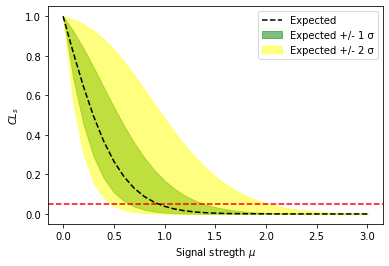

In [41]:
ax = plot_scan(mu_scan, results)
ax.set_xlabel("Signal stregth $\mu$")
ax.set_ylabel("$CL_s$")
ax.legend()

By looking where the red line crosses the expected line and the error bands we can conclude that the minimum signal strength we expect to exclude in case of no excess events is slightly below 1. We would expect that limit to fluctuate between $\approx$ 0.6 and 1.4 at $1\sigma$ level and 0.5 to 2 at $2\sigma$ level.

`pyhf` also has a convenience function to run the scan and interpolate this for us, so we don't need to read it from the plot with a ruler ;)

In [42]:
pyhf.infer.intervals.upper_limits.upper_limit([b] + model.config.auxdata, model)

(array(0.93802498),
 [array(0.47172138),
  array(0.64849741),
  array(0.93802498),
  array(1.3915076),
  array(2.02441462)])